In [1]:
import numpy as np
import pandas as pd

# Machine learning components
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/Users/ashenafi/code/shailendraveerasamy/Project-AI-Financial-Risk-Management/raw_data/creditcard.csv")
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-6.677212,5.529299,-7.193275,6.081321,-1.636071,0.500610,-4.640770,-4.339840,-0.950036,0.566680,...,5.563301,-1.608272,0.965322,0.163718,0.047531,0.466165,0.278547,1.471988,105.89,1
1,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
2,-4.446847,-0.014793,-5.126307,6.945130,5.269255,-4.297177,-2.591242,0.342671,-3.880663,-3.976525,...,0.247913,-0.049586,-0.226017,-0.401236,0.856124,0.661272,0.492560,0.971834,1.00,1
3,-1.309441,1.786495,-1.371070,1.214335,-0.336642,-1.390120,-1.709109,0.667748,-1.699809,-3.843911,...,0.533521,-0.022180,-0.299556,-0.226416,0.364360,-0.475102,0.571426,0.293426,1.00,1
4,0.206075,1.387360,-1.045287,4.228686,-1.647549,-0.180897,-2.943678,0.859156,-1.181743,-3.096504,...,0.469199,0.344930,-0.203799,0.376640,0.715485,0.226003,0.628545,0.319918,0.76,1


In [4]:
null_values = data.isna().sum()
null_values

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
duplicated_values = data.duplicated().sum()
duplicated_values

np.int64(206)

In [6]:
X = data.drop('Class', axis=1)
y = data['Class']

In [7]:
print(f" X shape: {X.shape}  y shape: {y.shape}")

 X shape: (28481, 29)  y shape: (28481,)


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
non_fraud_y = (y_train == 0).sum()
non_fraud_y

np.int64(22745)

In [10]:
fraud_y = (y_train == 1).sum()
fraud_y

np.int64(39)

In [11]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(583.2051282051282)

In [12]:
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False
)

In [13]:
# solve overfitting with StratifiedKFold and cross_val_score ...
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)# heps not to overfit

In [15]:
print("Performing 5-fold cross-validation...")
scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring='average_precision',  # PR AUC
    n_jobs=-1
)

model.fit(X_train, y_train)


# 3. Apply threshold
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.05).astype(int)

print(classification_report(y_test, y_pred))

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Performing 5-fold cross-validation...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.73      0.80      0.76        10

    accuracy                           1.00      5697
   macro avg       0.86      0.90      0.88      5697
weighted avg       1.00      1.00      1.00      5697

Accuracy: 0.9991223450939091

Confusion Matrix:
[[5684    3]
 [   2    8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.73      0.80      0.76        10

    accuracy                           1.00      5697
   macro avg       0.86      0.90      0.88      5697
weighted avg       1.00      1.00      1.00      5697



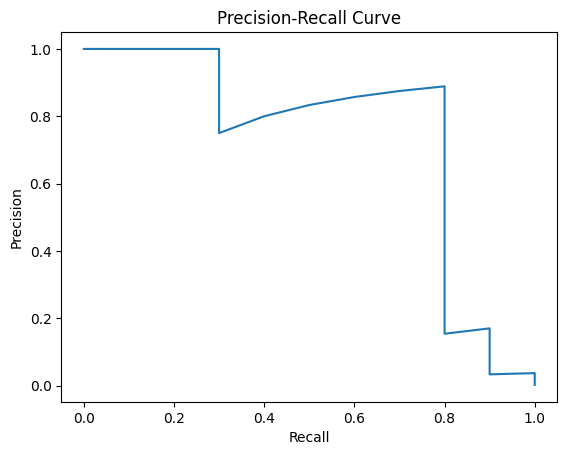

In [16]:
# Precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [77]:
for t in [0.01, 0.03, 0.05, 0.07, 0.10, 0.15]:
    y_pred = (y_proba >= t).astype(int)
    print(f"Threshold = {t}")
    print(classification_report(y_test, y_pred))


Threshold = 0.01
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.47      0.80      0.59        10

    accuracy                           1.00      5697
   macro avg       0.74      0.90      0.80      5697
weighted avg       1.00      1.00      1.00      5697

Threshold = 0.03
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.73      0.80      0.76        10

    accuracy                           1.00      5697
   macro avg       0.86      0.90      0.88      5697
weighted avg       1.00      1.00      1.00      5697

Threshold = 0.05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.73      0.80      0.76        10

    accuracy                           1.00      5697
   macro avg       0.86      0.90      0.88      5697
weighted avg       1.00